In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.stats.multitest as multi
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pickle

sns.set_style('white')
%matplotlib inline

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.weight'] = 'bold'

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

C:\Users\Jake\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load in absolute abundance data (dPCR)

In [2]:
df_rel_sort_list = pickle.load(open('pickle_files/rel_sort_lod_list.pkl', 'rb'))
df_abs_sort_list = pickle.load(open('pickle_files/abs_sort_lod_list.pkl', 'rb'))

df_pseudo_rel_sort_list = pickle.load(open('pickle_files/pseudo_rel_sort_lod_list.pkl', 'rb'))
df_pseudo_abs_sort_list = pickle.load(open('pickle_files/pseudo_abs_sort_lod_list.pkl', 'rb'))

df_col_names_list = pickle.load(open('pickle_files/col_names_lod_list.pkl', 'rb'))
metadata = pickle.load(open('pickle_files/metadata_all.pkl', 'rb'))

In [3]:
# Add total load to name dataframe for plotting purposes
for i in range(6):
    df_col_names_list[i].loc['Total Load'] = ['Total Load']*(4+i)

### Only keep the top 20 average abundance taxa and add total load column or all taxa with at least 10 values if less than 20 taxa present

In [4]:
df_abs_filter_list = [None]*6

# Filter out taxa with less than 10 values
for i in range(6):
    columns = df_abs_sort_list[i].sum(axis=0)[(df_abs_sort_list[i].astype(bool).sum(axis=0)>10)].index.tolist()
    df_abs_filter_list[i] = df_abs_sort_list[i][columns]

In [5]:
df_abs_top20_list = [None]*6

num=20

# Subset dataframe just to the top twenty average abundant taxa
for i in range(6):
    total_load = df_abs_sort_list[i].sum(axis=1)
    
    # If less than 20 total taxa (for phylum level) then take all taxa present
    if len(df_abs_sort_list[i].columns)>num:
        df_abs_top20_list[i] = pd.concat([total_load, df_abs_filter_list[i].iloc[:,:num]], axis=1).rename(columns={0:'Total Load'}).dropna()

    else:
        df_abs_top20_list[i] = pd.concat([total_load, df_abs_filter_list[i][df_abs_filter_list[i].columns[np.count_nonzero(df_abs_filter_list[i], axis=0)>5]]], axis=1).rename(columns={0:'Total Load'}).dropna()

## Calculate correlation coefficients and p-values (absolute abundance, Spearman)

In [6]:
df_abs_corr_list = [None]*6

# Calculate pairwise spearman correlation coefficients
for index in range(6):
    df_abs_corr_list[index] = pd.DataFrame(columns=['x', 'y', 'corr', 'p-val'])
    columns = df_abs_top20_list[index].columns
    count = 0
    for i in range(len(columns)):
        for j in range(len(columns)):
            corr, p_val = stats.spearmanr(df_abs_top20_list[index][columns[i]], df_abs_top20_list[index][columns[j]])
            df_abs_corr_list[index].loc[count] = [columns[i], columns[j], corr, p_val]
            count+=1

### Correct p-values for multiple hypothesis testing (Benjamini-Hochberg)

In [7]:
# Calculate benjamini-Hochberg corrected p-values
for i in range(6):
    df_abs_corr_list[i]['fdr p-val'] = multi.multipletests(df_abs_corr_list[i]['p-val'].tolist(), method='fdr_bh')[1]
    df_abs_corr_list[i]['-log10 fdr'] = -np.log10(df_abs_corr_list[i]['fdr p-val'])

C:\Users\Jake\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
'Function to draw heatmap figure'
def heatmap(x, y, size, color, x_plot_labels, y_plot_labels):
    fig = plt.figure(figsize=(15,14))
    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 grid
    ax = fig.add_subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot
    
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    
    # Mapping from column names to integer coordinates
    n_samp = len(y_labels)-1
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)}
    y_to_num = {p[1]:n_samp-p[0] for p in enumerate(y_labels)}

    size_scale = 1000
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 240, s=99, n=n_colors) # Create the palette
    
    x_pos = x.map(x_to_num)
    y_pos = y.map(y_to_num)

    ax.scatter(
        x=x_pos,
        y=y_pos,
        s=size * size_scale,
        c=[palette[200] if v>0 else palette[100] for v in color], # List of colors, blue if positive orange if negative
        marker='o',
        edgecolor='k',
        linewidth=0.1
    )
    
    ax.plot([0,1],[1,0], transform=ax.transAxes, color='k')

    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_plot_labels, rotation=45, horizontalalignment='left')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_plot_labels)
    ax.set_xlim([-1, max([v for v in x_to_num.values()]) + 1]) 
    ax.set_ylim([-1, max([v for v in y_to_num.values()]) + 1])
    
    # Add color legend on the right side of the plot
    ax = fig.add_subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

    col_x = [0]*len(palette) # Fixed x coordinate for the bars
    #bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

    #bar_height = bar_y[1] - bar_y[0]
    #ax.barh(
    #    y=bar_y,
    #    width=[5]*len(palette), # Make bars 5 units wide
    #    left=col_x, # Make bars start at 0
    #    height=bar_height,
    #    color=palette,
    #    linewidth=0
    #)
    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    ax.set_xticks([]) # Remove horizontal ticks
    #ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
    ax.set_yticks([]) # Show vertical ticks on the right
    
    leg_elements = [Patch(color='none', label='Correlation'),
                    Line2D([0], [0], marker='o', color=palette[200], label='Positive',
                      markerfacecolor=palette[200], markersize=20, linewidth=0),
                    Line2D([0], [0], marker='o', color=palette[100], label='Negative',
                      markerfacecolor=palette[100], markersize=20, linewidth=0),
                    Patch(color='none', label=''),
                    Patch(color='none', label='Coefficient'),
                    Line2D([0], [0], marker='o', color='w', label='0.1',
                      markerfacecolor='k', markersize=(0.1*1000)**0.5, linewidth=0),
                    Line2D([0], [0], marker='o', color='w', label='0.3',
                      markerfacecolor='k', markersize=(0.3*1000)**0.5, linewidth=0),
                    Line2D([0], [0], marker='o', color='w', label='0.5',
                      markerfacecolor='k', markersize=(0.5*1000)**0.5, linewidth=0),
                    Line2D([0], [0], marker='o', color='w', label='0.7',
                      markerfacecolor='k', markersize=(0.7*1000)**0.5, linewidth=0),
                    Line2D([0], [0], marker='o', color='w', label='0.9',
                      markerfacecolor='k', markersize=(0.9*1000)**0.5, linewidth=0)]
    
    ax.legend(handles=leg_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, labelspacing=0.9)
    

### Set size of markers based on correlation coefficient

In [9]:
for index in range(6):
    adjust_size = []
    for i in range(len(df_abs_corr_list[index]['x'].unique())):
        for j in range(len(df_abs_corr_list[index]['y'].unique())):
            if i != j:
                s = df_abs_corr_list[index].iloc[i+j*len(df_abs_corr_list[index]['x'].unique())]['-log10 fdr']
                corr = df_abs_corr_list[index].iloc[i+j*len(df_abs_corr_list[index]['x'].unique())]['corr']
                
                #Set size to zero if less than significance threshold, other scale with coefficient
                if s < 1.3:
                    adjust_size.append(0)
                else:
                    adjust_size.append(abs(corr))
            else:
                adjust_size.append(0)

    df_abs_corr_list[index]['size'] = adjust_size

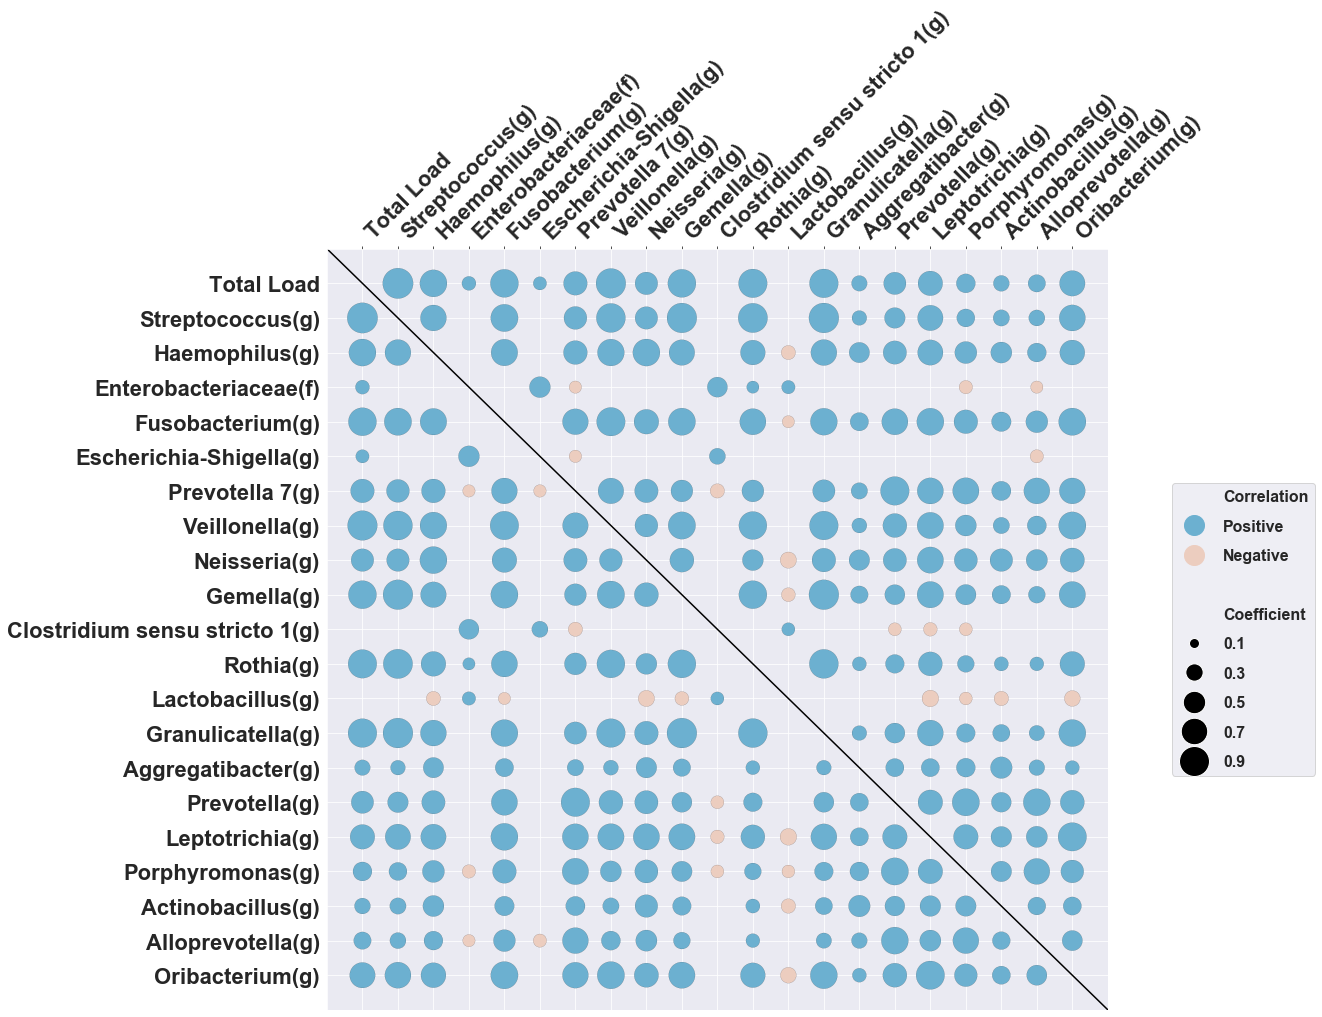

In [10]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_style('darkgrid')

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22

level = 4
labels = ['Total Load'] + pd.DataFrame(df_abs_filter_list[level].columns).merge(df_col_names_list[level][['label']], left_on=0, right_index=True)['label'].tolist()
heatmap(
    x=df_abs_corr_list[level]['x'],
    y=df_abs_corr_list[level]['y'],
    size=abs(df_abs_corr_list[level]['size']),
    color=df_abs_corr_list[level]['corr'],
    x_plot_labels = labels,
    y_plot_labels = labels
)

#plt.savefig('Absolute_corr_matrix.png', bbox_inches='tight', dpi=200)
#plt.savefig('Absolute_corr_matrix.pdf', bbox_inches='tight')

In [13]:
# Return plotting axis to normal
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

### Analyze the taxa that have greater co-correlation with another taxa than with total load

In [14]:
df_diff = pd.DataFrame(columns=['max_corr_taxon', 'max_corr', 'total_corr', 'diff'])

# Calculate difference between max taxa co-correlation and total load co-correlation
for index in df_abs_corr_list[level]['x'].unique():
    total_corr = df_abs_corr_list[level][(df_abs_corr_list[level]['x']==index) & (df_abs_corr_list[level]['y']=='Total Load')]['corr'].tolist()[0]
    max_corr = df_abs_corr_list[level][(df_abs_corr_list[level]['x']==index) & (df_abs_corr_list[level]['y']!=index)].sort_values('corr', ascending=False)['corr'].tolist()[0]
    max_corr_taxa = df_abs_corr_list[level][(df_abs_corr_list[level]['x']==index) & (df_abs_corr_list[level]['y']!=index)].sort_values('corr', ascending=False)['y'].tolist()[0]
    df_diff.loc[index] = [max_corr_taxa, max_corr, total_corr, max_corr-total_corr]

In [15]:
# Sort by difference and merge with taxa names
df_diff = df_diff.sort_values('diff', ascending=False).merge(df_col_names_list[level], left_index=True, right_index=True)[['max_corr_taxon', 'max_corr', 'total_corr', 'diff', 'label']]

In [16]:
taxa_corr_list = []

for index, row in df_diff.iterrows():
    taxa_corr_list.append(df_col_names_list[level].loc[row['max_corr_taxon']]['label'])
    
    
df_diff['corr_taxa_name'] = taxa_corr_list

In [17]:
df_diff.rename(columns={'label':'Taxa 1', 'corr_taxa_name':'Taxa 2'})

max_corr_taxon  max_corr  total_corr      diff  \
ASV24               ASV30  0.728528    0.301974  0.426554   
ASV23               ASV30  0.741157    0.358656  0.382501   
ASV30               ASV29  0.817961    0.496757  0.321204   
ASV81              ASV255  0.401648    0.128926  0.272722   
ASV247             ASV255  0.436819    0.175534  0.261285   
ASV29               ASV30  0.817961    0.556986  0.260975   
ASV257             ASV241  0.510538    0.250633  0.259904   
ASV255             ASV247  0.436819    0.195240  0.241579   
ASV258             ASV257  0.466316    0.240984  0.225332   
ASV241             ASV259  0.731211    0.508868  0.222343   
ASV192             ASV126  0.806178    0.603023  0.203155   
ASV71              ASV255  0.179363   -0.012615  0.191978   
ASV126             ASV192  0.806178    0.647607  0.158571   
ASV61               ASV68  0.886872    0.785328  0.101544   
ASV68               ASV76  0.888986    0.822939  0.066048   
ASV7                ASV76  0.858002    0.815137  0.042864   
ASV191             ASV188  0.810553    0.783742  0.026810   
ASV259             ASV241  0.731211    0.730974  0.000236   
ASV76          Total Load  0.920880    0.920880  0.000000   
ASV188         Total Load  0.878822    0.878822  0.000000   
Total Load          ASV76  0.920880    1.000000 -0.079120   

                                    Taxa 1                   Taxa 2  
ASV24                    Alloprevotella(g)            Prevotella(g)  
ASV23                     Porphyromonas(g)            Prevotella(g)  
ASV30                        Prevotella(g)          Prevotella 7(g)  
ASV81       Clostridium sensu stricto 1(g)    Enterobacteriaceae(f)  
ASV247             Escherichia-Shigella(g)    Enterobacteriaceae(f)  
ASV29                      Prevotella 7(g)            Prevotella(g)  
ASV257                   Actinobacillus(g)             Neisseria(g)  
ASV255               Enterobacteriaceae(f)  Escherichia-Shigella(g)  
ASV258                  Aggregatibacter(g)        Actinobacillus(g)  
ASV241                        Neisseria(g)           Haemophilus(g)  
ASV192                     Leptotrichia(g)          Oribacterium(g)  
ASV71                     Lactobacillus(g)    Enterobacteriaceae(f)  
ASV126                     Oribacterium(g)          Leptotrichia(g)  
ASV61                           Gemella(g)        Granulicatella(g)  
ASV68                    Granulicatella(g)         Streptococcus(g)  
ASV7                             Rothia(g)         Streptococcus(g)  
ASV191                    Fusobacterium(g)           Veillonella(g)  
ASV259                      Haemophilus(g)             Neisseria(g)  
ASV76                     Streptococcus(g)               Total Load  
ASV188                      Veillonella(g)               Total Load  
Total Load                      Total Load         Streptococcus(g)

In [18]:
# Export interesting taxa relationships to excel table (Supplemental Table)
#df_diff.iloc[[0,1,2,3, 8, 11, 15, 18]].to_excel('Table_S3.xlsx')

### Plot the total microbial load distribution

C:\Users\Jake\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Jake\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


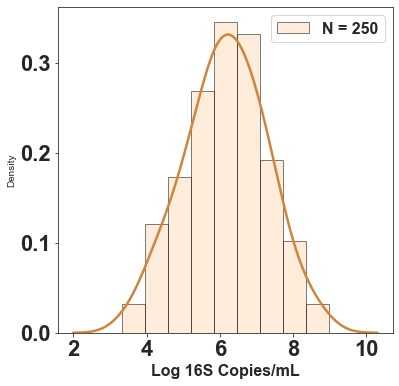

In [19]:
sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

pal = sns.cubehelix_palette(11, rot=-.25, light=0.7)

sns.distplot(metadata['Log Copies/mL'],
             kde_kws={"color": 'peru', "lw": 2.5, "bw":0.4},
             hist_kws={"alpha": 0.5, "color": 'peachpuff', 'edgecolor':'k'},
             label='N = 250',
             bins=9)
ax1.set_xlabel('Log 16S Copies/mL', fontsize=16, fontweight='bold')
ax1.legend(fontsize=16)

#fig.savefig('total_load_dist.png', bbox_inches='tight', dpi=200)
#fig.savefig('total_load_dist.pdf', bbox_inches='tight', transparent=True)

In [21]:
# Color palette
pal = sns.cubehelix_palette(20, rot=-.25, light=0.7)

C:\Users\Jake\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Jake\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\Jake\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning

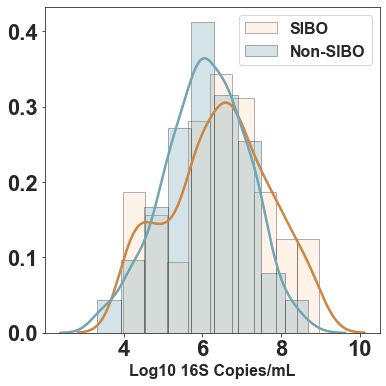

In [27]:
sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

pal = sns.cubehelix_palette(11, rot=-.25, light=0.7)

sns.distplot(metadata[metadata['SIBO']==1]['Log Copies/mL'],
             kde_kws={"color": 'peru', "lw": 2.5, "bw":0.3},
             hist_kws={"alpha": 0.3, "color": 'peachpuff', 'edgecolor':'k'},
             label='SIBO',  # N=58
             bins=9)
sns.distplot(metadata[metadata['SIBO']==0]['Log Copies/mL'],
             kde_kws={"color": pal[2], "lw": 2.5, "bw":0.3},
             hist_kws={"alpha": 0.3, "color": pal[2], 'edgecolor':'k'},
             label='Non-SIBO', # N=192
             bins=9)
ax1.set_xlabel('Log10 16S Copies/mL', fontsize=16, fontweight='bold')
ax1.set_ylabel('')
ax1.legend(fontsize=16)

fig.savefig('SIBOvNonSIBO_total_load_dist.png', bbox_inches='tight', dpi=200)
fig.savefig('SIBOvNonSIBO_total_load_dist.pdf', bbox_inches='tight', transparent=True)

### Compare total load distribution to log-normal distribution with QQ-plot

Text(0.5, 0, 'Theoretical Quantiles')

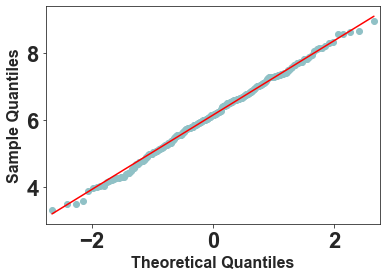

In [26]:
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

seed(1)

data = np.array(metadata['Log Copies/mL'])

qqplot(data, line='s', color=pal[0])
pyplot.ylabel('Sample Quantiles', fontsize=16, fontweight='bold')
pyplot.xlabel('Theoretical Quantiles', fontsize=16, fontweight='bold')
#pyplot.savefig('QQ_plot.png', bbox_inches='tight')
#pyplot.savefig('QQ_plot.pdf', transparent=True, bbox_inches='tight')

## Distribution of genera with >50% prevalence

In [27]:
# List of taxa with prevalence greater than 50%
most_prevalent_50 = list((df_abs_sort_list[4] == 0).astype(int).sum(axis=0).sort_values().head(n=11).index)

In [28]:
# Format data for ridgeline plots
df_prevalent_50 = df_abs_sort_list[4][most_prevalent_50].merge(metadata[['Copies/mL']], left_index=True, right_index=True).rename(columns={'Copies/mL':'Total Load'})
df_prevalent_50 = df_prevalent_50[df_prevalent_50.columns.tolist()[-1:]+df_prevalent_50.columns.tolist()[:-1]]

df = pd.melt(df_prevalent_50, var_name='Taxon', value_name='Load')
df['Log10 Load'] = np.log10(df['Load'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
#df['Corrected Log10 Load'] = df['Log10 Load'].apply(lambda x: np.nan if x <= 1 else x)
df = df.merge(df_col_names_list[4], left_on=['Taxon'], right_index=True)
value_counts = df.dropna(axis=0)['label'].value_counts()

C:\Users\Jake\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


C:\Users\Jake\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\Jake\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\Jake\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\Jake\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecat

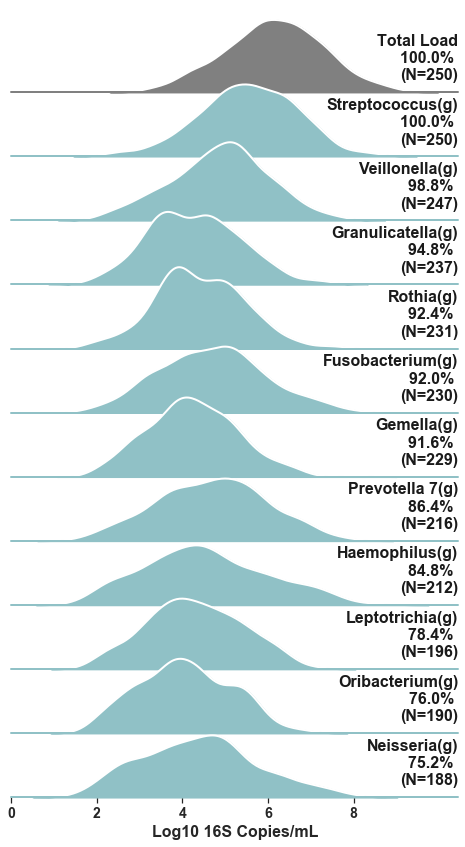

In [29]:
sns.set(style='white', rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.cubehelix_palette(20, rot=-.25, light=0.7)
g = sns.FacetGrid(df, row="label", hue="label", aspect=7, height=1, palette=['grey']+[pal[0]]*11)

g.map(sns.kdeplot, "Log10 Load", clip_on=False, shade=True, alpha=1, lw=1.5, bw=0.3)
g.map(sns.kdeplot, "Log10 Load", clip_on=False, color="w", lw=2, bw=0.3)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(1, 0.4, label + '\n' + str(round(value_counts[label]/len(df_pseudo_abs_sort_list[0])*100,1)) + '% \n(N=' + str(value_counts[label]) + ')', fontweight="bold", color='k',
           ha="right", va="center", transform=ax.transAxes, fontsize=16)
    
g.map(label, "Log10 Load")
g.fig.subplots_adjust(hspace=-0.25)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.set_xlabels('Log10 16S Copies/mL', fontsize=16, fontweight='bold')
g.axes[11,0].xaxis.set_ticks_position('bottom')
g.axes[11,0].tick_params(axis='x', labelsize = 14)
g.axes[11,0].set_xticks(np.arange(0, 10, 2.0))
#g.savefig('50%_prevalence_ridgeplot_col1.png', dpi=200, bbox_inches='tight')
#g.savefig('50%_prevalence_ridgeplot_col1.pdf', bbox_inches='tight', transparent=True)

In [30]:
# Next column of prevalent taxa
most_prevalent_50 = list((df_abs_sort_list[4] == 0).astype(int).sum(axis=0).sort_values()[11:23].index)

In [31]:
df_prevalent_50 = df_abs_sort_list[4][most_prevalent_50]

df = pd.melt(df_prevalent_50, var_name='Taxon', value_name='Load')
df['Log10 Load'] = np.log10(df['Load'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
#df['Corrected Log10 Load'] = df['Log10 Load'].apply(lambda x: np.nan if x <= 1 else x)
df = df.merge(df_col_names_list[4], left_on=['Taxon'], right_index=True)
value_counts = df.dropna(axis=0)['label'].value_counts()

C:\Users\Jake\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


C:\Users\Jake\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\Jake\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\Jake\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\Jake\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecat

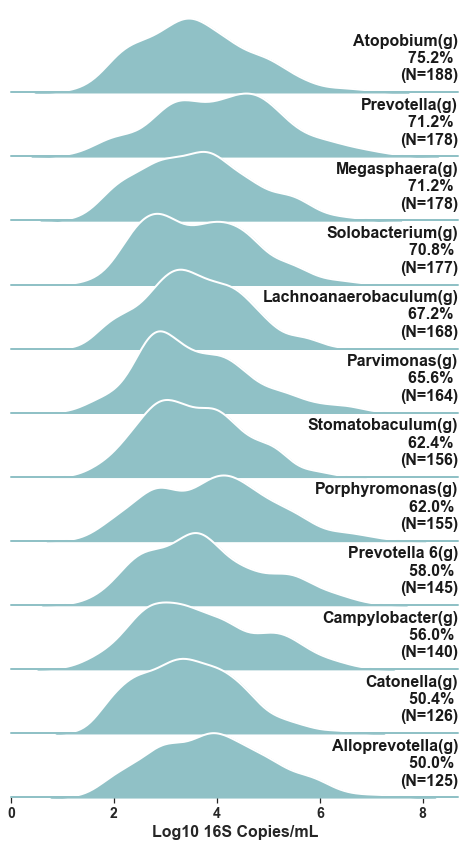

In [32]:
sns.set(style='white', rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.cubehelix_palette(20, rot=-.25, light=0.7)
g = sns.FacetGrid(df, row="label", hue="label", aspect=7, height=1, palette=[pal[0]]*12)

g.map(sns.kdeplot, "Log10 Load", clip_on=False, shade=True, alpha=1, lw=1.5, bw=0.3)
g.map(sns.kdeplot, "Log10 Load", clip_on=False, color="w", lw=2, bw=0.3)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(1, 0.4, label + '\n' + str(round(value_counts[label]/len(df_pseudo_abs_sort_list[0])*100,1)) + '% \n(N=' + str(value_counts[label]) + ')', fontweight="bold", color='k',
           ha="right", va="center", transform=ax.transAxes, fontsize=16)
    
g.map(label, "Log10 Load")
g.fig.subplots_adjust(hspace=-0.25)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.set_xlabels('Log10 16S Copies/mL', fontsize=16, fontweight='bold')
g.axes[11,0].xaxis.set_ticks_position('bottom')
g.axes[11,0].tick_params(axis='x', labelsize = 14)
g.axes[11,0].set_xticks(np.arange(0, 10, 2.0))
#g.savefig('50%_prevalence_ridgeplot_col2.png', dpi=200, bbox_inches='tight')
#g.savefig('50%_prevalence_ridgeplot_col2.pdf', bbox_inches='tight', transparent=True)

### Rank taxa by the difference between their max value and mean value

In [33]:
level = 4

#First sort for taxa with a max load > 1e6
_df = df_pseudo_abs_sort_list[level].loc[:,(np.log10(df_abs_sort_list[level].max()))>6]

# Sort by difference between max and mean abundance
df_potential_disruptor = pd.DataFrame((np.log10(_df.max())-np.log10(_df+1).mean()).sort_values(ascending=False)).merge(df_col_names_list[level][['label']], 
                                                                                                                       left_index=True, 
                                                                                                                       right_index=True).head(n=50)
df_potential_disruptor.head()

0                            label
ASV81   7.014256   Clostridium sensu stricto 1(g)
ASV247  6.867911          Escherichia-Shigella(g)
ASV255  6.518217            Enterobacteriaceae(f)
ASV258  6.156776               Aggregatibacter(g)
ASV197  6.152187  SR1 bacterium oral taxon 875(g)

### Co-correlation of potential disruptor taxa

In [34]:
# Create list of potential disruptor taxa for co-correlation plot
disruptor_list = ['ASV255', 'ASV247', 'ASV81', 'ASV70', 'ASV142', 'ASV219', 'ASV11', 'ASV71', 'ASV243', 'ASV258', 'ASV257', 'ASV163', 'ASV197', 'ASV242', 'ASV239', 'ASV260', 'ASV30', 'ASV191']
disruptor_label = []
for value in disruptor_list:
    disruptor_label.append(df_col_names_list[4].loc[value]['label'])

[Text(0, 0.5, 'Enterobacteriaceae(f)'),
 Text(0, 1.5, 'Escherichia-Shigella(g)'),
 Text(0, 2.5, 'Clostridium sensu stricto 1(g)'),
 Text(0, 3.5, 'Enterococcus(g)'),
 Text(0, 4.5, 'Romboutsia(g)'),
 Text(0, 5.5, 'Aeromonas(g)'),
 Text(0, 6.5, 'Bacteroides(g)'),
 Text(0, 7.5, 'Lactobacillus(g)'),
 Text(0, 8.5, 'Cardiobacterium(g)'),
 Text(0, 9.5, 'Aggregatibacter(g)'),
 Text(0, 10.5, 'Actinobacillus(g)'),
 Text(0, 11.5, 'Ruminococcaceae UCG-014(g)'),
 Text(0, 12.5, 'SR1 bacterium oral taxon 875(g)'),
 Text(0, 13.5, 'Neisseriaceae(f)'),
 Text(0, 14.5, 'Eikenella(g)'),
 Text(0, 15.5, 'Pasteurellaceae(f)'),
 Text(0, 16.5, 'Prevotella(g)'),
 Text(0, 17.5, 'Fusobacterium(g)')]

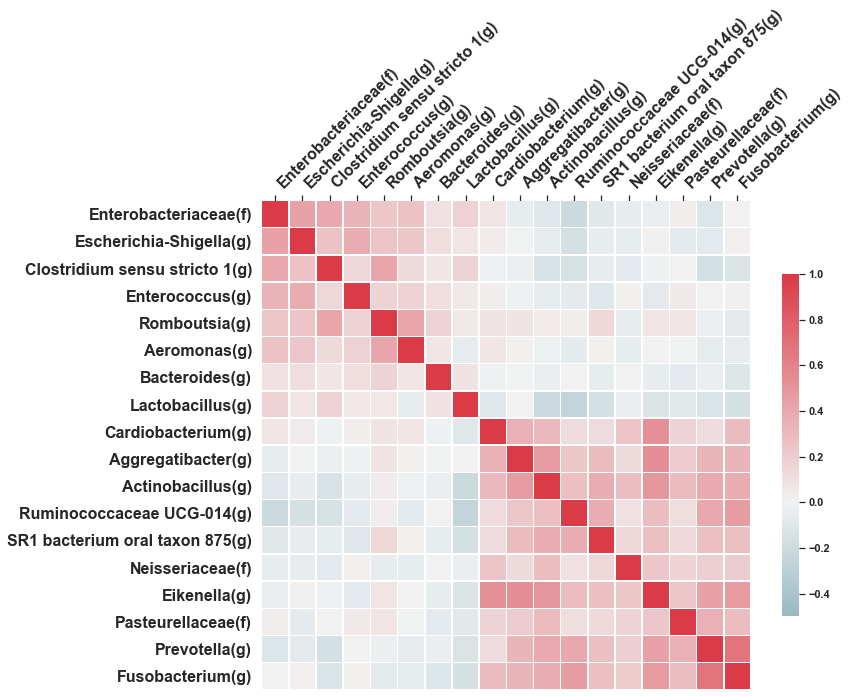

In [35]:
sns.set_style('white')
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

_df = df_abs_sort_list[4][disruptor_list]

# Compute the correlation matrix
corr = _df.corr(method='spearman')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1, vmin=-0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

ax.set_xticklabels(disruptor_label, fontsize=16, rotation=45, horizontalalignment='left')
ax.set_yticklabels(disruptor_label, fontsize=16)

#f.savefig('disruptor_heatmap.png', bbox_inches='tight', dpi=200)
#f.savefig('disruptor_heatmap.pdf', bbox_inches='tight', transparent=True)